In [1]:
import neptune as neptune
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker

from misc import (
    plot_module,
    plot_multiple_modules,
    get_steps_from_first_run,
    pivot_dict,
    plot_loss_vs_lr,
)

## Neptune

In [2]:
def get_neptune_table(tags, negative_tags=None, columns=None):
    """
    Fetches a Neptune runs table filtered by tags and returns it as a pandas DataFrame.

    Parameters:
    - tags (list): List of tags to filter the runs.
    - negative_tags (list, optional): List of tags to exclude from the runs.
    - columns (list, optional): Additional columns to include in the runs table.

    Returns:
    - pandas.DataFrame: The runs table with the specified filters and columns.
    """

    # Initialize the Neptune project
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token=os.environ["NEPTUNE_API_TOKEN"],
    )

    # Fetch the runs table with the specified tags and columns
    runs_table = project.fetch_runs_table(tag=tags, columns=columns).to_pandas()

    # Ensure 'sys/tags' is a list for each run
    runs_table["sys/tags"] = runs_table["sys/tags"].apply(
        lambda x: x.split(",") if isinstance(x, str) else x
    )

    # Exclude runs containing any of the negative tags
    if negative_tags:
        for neg_tag in negative_tags:
            runs_table = runs_table[
                ~runs_table["sys/tags"].apply(lambda x: neg_tag in x)
            ]

    print(f"Table downloaded\nShape: {runs_table.shape}")
    return runs_table


def get_activations(runs_table):
    activation_dict = {}
    for i, run_row in runs_table.iterrows():
        # dmodel = 2 ** (i + 4)
        dmodel = run_row["args/dmodel"]
        run_id = run_row["sys/id"]  # Assuming 'sys/id' is the run identifier
        print(f"run ID: {run_id}")
        project_name = "pmtest/llm-random"
        # run_id = "LLMRANDOM-2078"
        run = neptune.init_run(
            project=project_name,
            with_id=run_id,
            mode="read-only",
            api_token=os.environ["NEPTUNE_API_TOKEN"],
        )
        print(f'run keys\n{run["block_0/residual_attention"]}')
        single_run_data = {"dmodel": dmodel}
        print(f'n_blocks: {run["args/n_blocks"].fetch()}')
        for i in range(run_row["args/n_blocks"]):
            single_run_data[i] = {
                "attn": run[
                    f"block_{i}/residual_attention/muP/mean_abs_update"
                ].fetch_values(),
                "FF": run[
                    f"block_{i}/residual_feedforward/muP/mean_abs_update"
                ].fetch_values(),
            }
        single_run_data["UNKNOWN"] = {
            "embedding": run[
                f"block_UNKNOWN/embedding_layer/muP/mean_abs_update"
            ].fetch_values(),
            "head": run[f"block_UNKNOWN/head/muP/mean_abs_update"].fetch_values(),
        }
        activation_dict[run_id] = single_run_data
    return activation_dict

## Plot

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (144, 1483)
(144, 1483)
[ 6.850625    6.58989583  6.39739583  6.19395833  5.95635417  5.6928125
  5.5115625   5.58697917  5.63125     5.83458333  6.45072917 24.2125    ]
[  6.60625      6.4159375    6.20875      5.971875     5.71395833
   5.62177083   5.57375      5.66677083   5.81927083   6.43739583
  19.37479167 128.49666667]
[6.41937500e+00 6.21697917e+00 5.97697917e+00 5.71437500e+00
 5.54885417e+00 5.55312500e+00 5.71958333e+00 5.84718750e+00
 6.33760417e+00 1.36085417e+01 5.82980000e+02 2.06621333e+04]
[6.21031250e+00 5.94302083e+00 5.70479167e+00 5.52541667e+00
 5.46166667e+00 5.69197917e+00 6.20885417e+00 6.23822917e+00
 8.46500000e+00 3.25345833e+02 5.62780000e+02 5.83441408e+06]


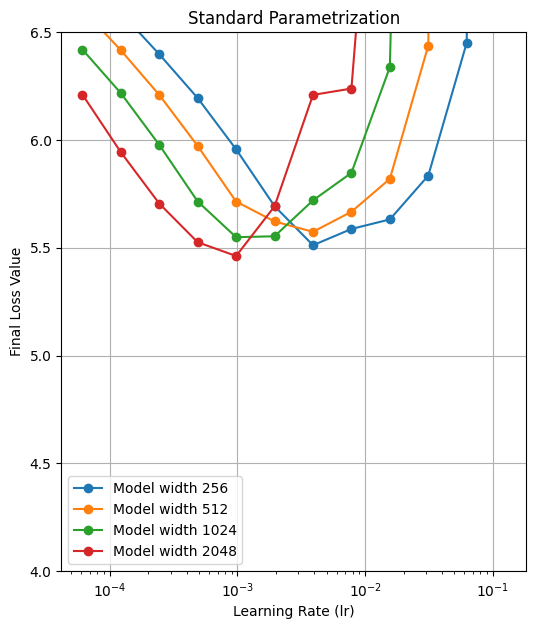

In [3]:
tags = ["muP_MoE", "muTransfer", "kc_reference_grid", "kc_version_3", "like_blog"]

df = get_neptune_table(tags)
print(df.shape)
plot_loss_vs_lr(df, (4, 6.5), figsize=(6, 7), title="Standard Parametrization")

In [8]:
tags = [
    "muP_MoE",
    "muTransfer",
    "kc_mup_extrapolation",
    "kc_version_3",
    "extrapol_2",
    "weight_decay=0.01",
]

df = get_neptune_table(tags)
print(df.shape)

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (84, 975)
(84, 975)


[5.20875    5.05239583 4.97739583 4.96416667 4.99770833 5.5778125
 5.6525    ]
[5.00729167 4.76927083 4.62364583 4.596875   4.61375    4.75458333
 5.31708333]
[4.8940625  4.57677083 4.3884375  4.345      4.35666667 4.5203125
 4.8334375 ]
[4.8234375  4.465      4.23645833 4.17692708 4.1871875  4.34541667
 4.7128125 ]


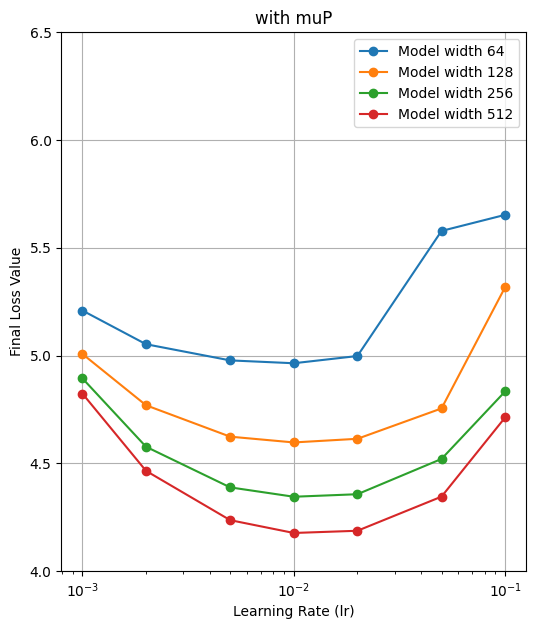

In [9]:
plot_loss_vs_lr(df, (4, 6.5), figsize=(6, 7), title="with muP")

In [14]:
# tags = ['muP_MoE', 'extrapolation']
# tags = ['muP_MoE', 'mup_grid_2', 'weight_decay=0.01', 'learning_rate=1e-2']
tags = [
    "muP_MoE",
    "muTransfer",
    "10_step",
    "kc_version_3",
    "constant_dhead",
    "like_mup",
]

df = get_neptune_table(tags)
print(df.shape)

https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (25, 408)
(25, 408)


In [15]:
act_dict = get_activations(df)
print(act_dict)

run ID: LLMRANDOM-27115
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-27115
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-27114
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-27114
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-27113
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-27113
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-27112
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-27112
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-27111
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-27111
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-27110
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-27110
run keys
<Namespace field at "block_0/residual_attention">
n_blocks: 2
run ID: LLMRANDOM-27109
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM

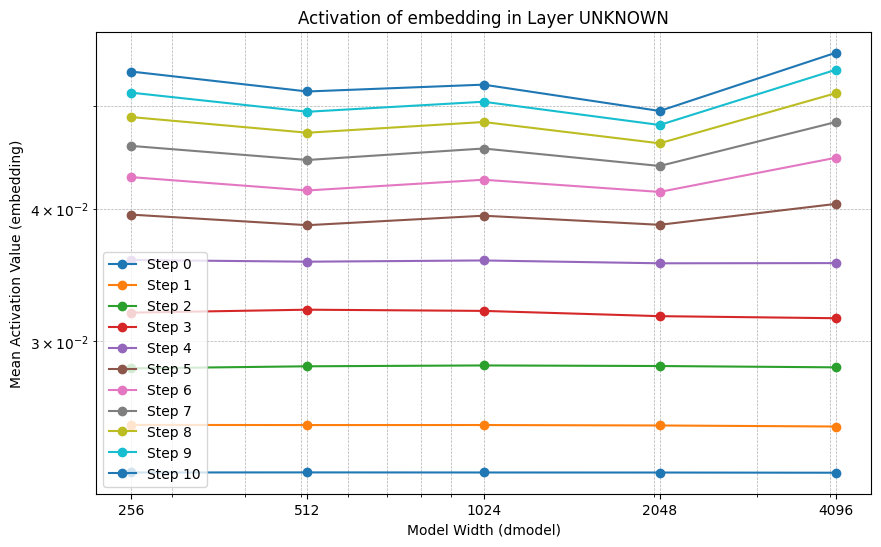

In [16]:
steps = get_steps_from_first_run(act_dict)
layer_num = "UNKNOWN"
module = "embedding"
# layer_num = 3
# module='FF'
pivoted_dict = pivot_dict(
    activations_dict=act_dict,
    steps=steps,
    dmodels=[256, 512, 1024, 2048, 4096],
    layer_num=layer_num,
    module=module,
)
plot_module(
    pivoted_dict=pivoted_dict,
    module_keyword=module,
    layer_num=layer_num,
    step_interval=1,
)

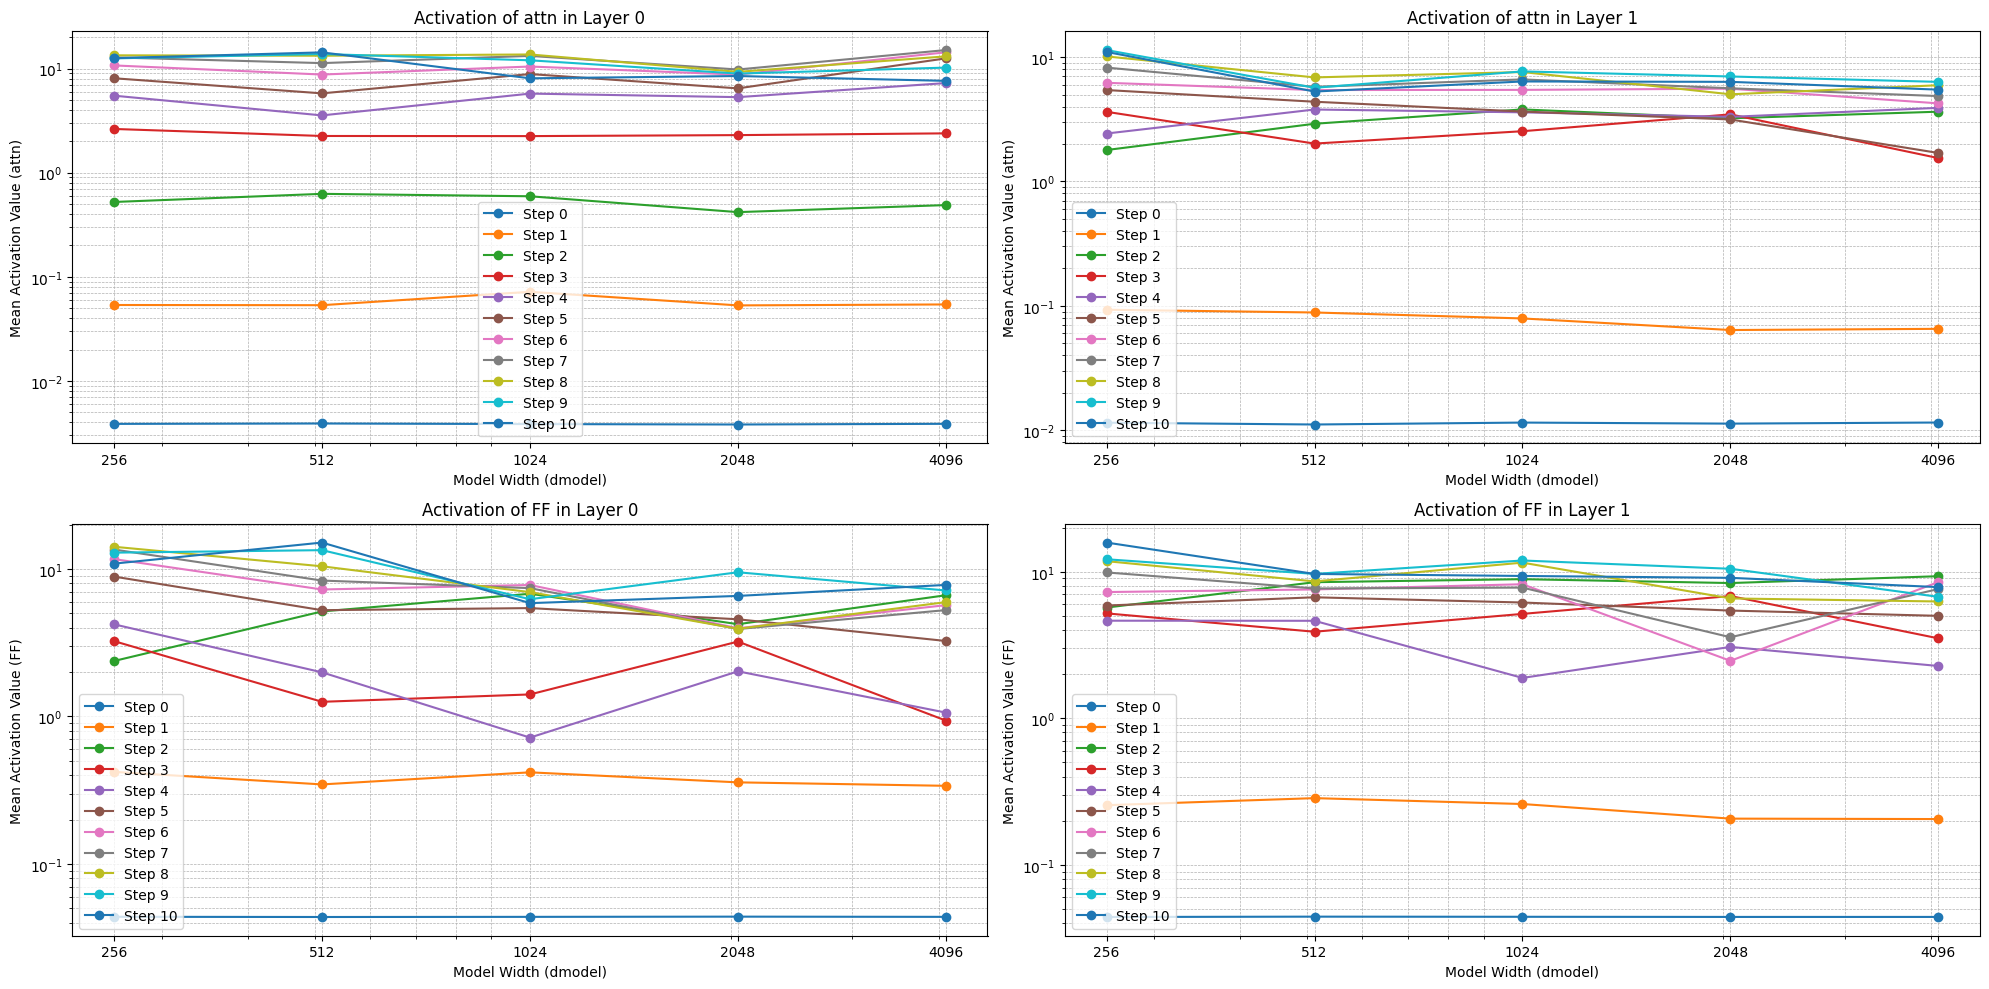

In [17]:
plot_multiple_modules(
    activations_dict=act_dict,
    module_keywords=["attn", "FF"],
    layer_nums=[0, 1],
    step_interval=1,
    figsize=(20, 10),
    dmodels=[256, 512, 1024, 2048, 4096],
)

In [10]:
import torch


def truncated_normal_(tensor, mean=0.0, std=1.0, lower=-2.0, upper=2.0):
    """
    Initializes a tensor with truncated normal distribution.

    Args:
        tensor (torch.Tensor): Tensor to be initialized.
        mean (float): Mean of the normal distribution.
        std (float): Standard deviation of the normal distribution.
        lower (float): Lower bound of truncation.
        upper (float): Upper bound of truncation.
    """
    # Calculate the bounds in standard deviations
    lower_bound = (lower - mean) / std
    upper_bound = (upper - mean) / std

    # Use torch's trunc_normal_ if available
    with torch.no_grad():
        size = tensor.shape
        truncated = torch.fmod(
            torch.normal(mean=mean, std=std, size=size), upper_bound - lower_bound
        )
        tensor.copy_(torch.clamp(truncated, min=lower, max=upper))


# Example usage
v = 100
d = 5
x = torch.zeros(v)
x[5] += 1.0
print(f"x[:10] = {x[:10]}")
matrix = torch.empty(v, d)  # Create an empty 5x5 tensor
std_base = 1.0
truncated_normal_(matrix, mean=0.0, std=std_base, lower=-2.0, upper=2.0)
print(f"base norm: {torch.norm(x@matrix)/np.sqrt(d)}\tstd: {torch.std(x@matrix)}")

e = 1000
# x = torch.rand(v)
matrix = torch.empty(v, e)  # Create an empty 5x5 tensor
m_d = e / d
truncated_normal_(matrix, mean=0.0, std=std_base, lower=-2.0, upper=2.0)
# matrix *= (1 / np.sqrt(m_d))
print(f"extrpl norm: {torch.norm(x@matrix)/np.sqrt(e)}\tstd: {torch.std(x@matrix)}")

x[:10] = tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
base norm: 1.0908429622650146	std: 1.1692359447479248
extrpl norm: 0.9673864841461182	std: 0.9678685069084167


In [11]:
def grid_time(exp_time, num_exps, num_gpus):
    grid_time_on_1_gpu = exp_time * num_exps
    print(f"grid_time_on_1_gpu: {grid_time_on_1_gpu}")
    total_time = grid_time_on_1_gpu / num_gpus
    return total_time


exp_time = 3.5 / 60
num_exps = 6 * 5**3
num_gpus = 8

print(f"num exps: {num_exps}")
total_time = grid_time(exp_time=exp_time, num_exps=num_exps, num_gpus=num_gpus)
print(f"grid time: {total_time:.2f} h")

num exps: 750
grid_time_on_1_gpu: 43.75
grid time: 5.47 h
